In [8]:
# R PACKAGES
if(!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse,readxl, arrow, janitor,  comorbidity)

Loading required package: pacman


Check Files are available

In [44]:
required_paths <- c(
  "mimic-iv-ed-2.2/ed/diagnosis.csv.gz",
  "mimic-iv-ed-2.2/ed/edstays.csv.gz",
  "mimic-iv-ed-2.2/ed/medrecon.csv.gz",
  "mimic-iv-ed-2.2/ed/pyxis.csv.gz",
  "mimic-iv-ed-2.2/ed/triage.csv.gz",
  "mimic-iv-ed-2.2/ed/vitalsign.csv.gz",
  "hosp/patients.csv.gz",
  "hosp/d_icd_diagnoses.csv.gz",
  "hosp/diagnoses_icd.csv.gz",
  "NYU_ED_Algorithm_-_ICD-9_Codes_-_6.23.15.xlsx",
  "NYU ED Algorithm - ICD10 Codes - Updated 2.4.25.xlsx",
  "hesr12638-sup-0007-appendixs7.txt",
  "hesr12638-sup-0007-appendixs7.txt"
)

missing_paths <- required_paths[!file.exists(path.expand(required_paths))]

if (length(missing_paths) > 0) {
  stop(paste("The following required files or directories are missing:\n",
             paste(missing_paths, collapse = "\n"),"See README for more information."))
} else {
  print("All required files are available.")
}

[1] "All required files are available."


# Join

In [10]:
# Create arrow table for edstays
ed_stays <- read_csv(
  "mimic-iv-ed-2.2/ed/edstays.csv.gz",
  show_col_types = F
  ) |> 
  mutate(
       subject_id = as.integer(subject_id),
       stay_id = as.integer(stay_id),
       hadm_id= as.integer(hadm_id),
  ) |> 
  arrow_table()

In [11]:
# Create the triage table and join to ed_stays 
triage <- read_csv(
  "mimic-iv-ed-2.2/ed/triage.csv.gz",
  show_col_types = F
  ) |>
  mutate(
       stay_id = as.integer(stay_id)
  ) |> 
  select(-subject_id) |> 
  arrow_table()

ed_join <- ed_stays |> 
  left_join(triage, join_by(stay_id))

In [12]:
# Create Patients table and join to ed_join.
## Create the DOB variable
## Patients file is from MIMIC-IV hosp module
patients <- read_csv(
  "hosp/patients.csv.gz",
  show_col_types = F
  ) |>
  mutate(
       subject_id = as.integer(subject_id),
       anchor_dob = anchor_year - anchor_age,
       anchor_year_start = str_trunc(
            anchor_year_group, 
            width = 4, 
            ellipsis = "", 
            side = "right"
       )
  ) |>
  select(-gender) |> # gender is already in ed_join
  arrow_table()

ed_join <- ed_join |>
  left_join(patients, join_by(subject_id))

In [13]:
# Create diagnosis tables
## If not admitted, diagnosis taken from ED module.
## If admitted, diagnosis is taken from hosp module in main mimic diagnosis table

# ED Diagnosis Table
diagnosis <- read_csv(
     "mimic-iv-ed-2.2/ed/diagnosis.csv.gz",
     show_col_types = F
     ) |> 
     mutate(
          subject_id = as.integer(subject_id),
          stay_id = as.integer(stay_id)
     ) |> 
     rename(
          ed_icd_code = icd_code,
          ed_icd_title = icd_title,
          ed_icd_version = icd_version,
          ed_seq_num = seq_num
     ) |>
     arrange(subject_id, stay_id, ed_seq_num) |> 
     group_by(subject_id, stay_id) |>
     collect() |> 
     mutate(
          ed_icd_code = str_flatten(ed_icd_code, ", "),
          ed_icd_title = str_replace_all(ed_icd_title, ", ", " "),
          ed_icd_title = str_flatten(ed_icd_title, ", "),
          ed_seq_num = str_flatten(ed_seq_num, ", ")
     ) |> 
     ungroup() |>
     distinct(subject_id, stay_id, .keep_all = T) |>
     arrow_table()

## Join to ed_join
ed_join <- ed_join |>
     left_join(diagnosis |> 
          select(-subject_id), 
     join_by( "stay_id")) |> 
     compute()

# Hosp Diagnosis table
## Hosp Descriptions file
dis_icd_desc  <- read_csv(
     "hosp/d_icd_diagnoses.csv.gz", 
     show_col_types = F
     ) |> 
     arrow_table()

## Hosp Diagnosis codes
dis_icd  <-  read_csv(
     "hosp/diagnoses_icd.csv.gz", 
     show_col_types = F
     ) |> 
     arrow_table()

## Join Hosp Diagnosis codes to Hosp descriptions
hosp_diagnosis <- dis_icd |>
     left_join(dis_icd_desc, join_by("icd_code", "icd_version")) |> 
     rename(
          hosp_icd_code = icd_code,
          hosp_icd_title = long_title,
          hosp_icd_version = icd_version,
          hosp_seq_num = seq_num
     ) |> 
     mutate(
          subject_id = as.integer(subject_id),
          hadm_id = as.integer(hadm_id),
          hosp_icd_title = str_replace_all(
               hosp_icd_title, ", ", " ")
     ) |> 
     arrange(subject_id, hadm_id, hosp_seq_num) |> 
     group_by(subject_id, hadm_id) |>
     collect() |> 
     mutate(
          hosp_icd_code = str_flatten(hosp_icd_code, ", "),
          hosp_icd_title = str_flatten(hosp_icd_title, ", "),
          hosp_seq_num = str_flatten(hosp_seq_num, ", ")
     ) |> 
     ungroup() |>
     distinct(subject_id, hadm_id, .keep_all = T) |>
     arrow_table() |> 
     semi_join(ed_stays, join_by("subject_id", "hadm_id"))
     
## Join to ed_join
ed_join <- ed_join |>
     left_join(hosp_diagnosis, join_by("subject_id", "hadm_id")) |> 
     compute()

# # Create columns for diagnoses based on whether they were admitted or not
# ## Get the primary code and primary title
ed_join <- ed_join |>
     collect() |>
     mutate(
          icd_codes = ifelse(!is.na(hadm_id), hosp_icd_code, ed_icd_code),
          icd_titles = ifelse(!is.na(hadm_id), hosp_icd_title, ed_icd_title),
          icd_version = ifelse(!is.na(hadm_id), hosp_icd_version, ed_icd_version),
          # extract the first code and title
          primary_code = str_extract(icd_codes, "^[^,]*"),
          primary_title = str_extract(icd_titles, "^[^,]*")
     ) |> 
     select(
          -hosp_icd_code,
          -ed_icd_code,
          -hosp_icd_title,
          -ed_icd_title,
          -hosp_icd_version,
          -ed_icd_version
     ) |> 
     # A small number (380) of patients have no discharge diagnosis
     # so I will remove them
     filter(!is.na(primary_code)) |> 
     arrow_table()

In [14]:
# Create the medications tables and join
# For the medications, I only want 1 row per patient. 

# Patient's meds
med_d  <-  read_csv(
  "mimic-iv-ed-2.2/ed/medrecon.csv.gz",
  show_col_types = F
  ) |>
  mutate(
      name = str_to_lower(name) 
  ) |> 
  group_by(stay_id) |> 
  mutate(
       med_names = str_flatten(name, "; "),
       med_gsn_count = n_distinct(gsn, na.rm = FALSE)
       ) |> 
  ungroup() |> 
  select(stay_id, med_gsn_count, med_names)  |> 
  distinct(stay_id, .keep_all = T) |> 
  mutate(
       stay_id = as.integer(stay_id)
  ) |> 
  arrow_table()

# Prescribed meds
psx <- read_csv(
  "mimic-iv-ed-2.2/ed/pyxis.csv.gz",
  show_col_types = F
  ) |>
 group_by(stay_id) |> 
 mutate(
  pres_names = str_flatten(name, "; "),
  pre_gsn_count = n_distinct(gsn)
 ) |> 
 ungroup() |>
 select(stay_id, pre_gsn_count, pres_names) |>
 distinct(stay_id, .keep_all = T) |>      
 mutate(
       stay_id = as.integer(stay_id)
  ) |> 
  arrow_table()

ed_join <- ed_join |>
  left_join(med_d, join_by("stay_id")) |>
  left_join(psx, join_by("stay_id")) |> 
  compute()

In [15]:
# Create the vitals table and join
vital  <- read_csv(
  "mimic-iv-ed-2.2/ed/vitalsign.csv.gz",
  show_col_types = F,
  ) |>
  select(-subject_id) |>
  group_by(stay_id) |>
  # Only take the final reading
  slice_max(n=1,order_by = charttime) |>
  ungroup() |>
  mutate(
    stay_id = as.integer(stay_id)
   ) |> 
  rename(
    vital_temp = temperature,
    vital_hr = heartrate,
    vital_rr = resprate,
    vital_o2 = o2sat,
    vital_sbp = sbp,
    vital_dbp = dbp,
    vital_pain = pain,
  ) |> 
  arrow_table() 

ed_join <- ed_join |>
  left_join(vital, join_by("stay_id")) |> 
  compute()

# Wrangle

## Clean

Create age bins

In [16]:
# Calculate age
ed_join <- ed_join |> 
  mutate(
        in_year = year(intime),
        age = in_year - anchor_year + anchor_age
      )  |> 

  # Calculate the age bins 
  mutate(# Create age bins for later analysis
    age_bin = ifelse(!is.na(age) & age < 18, "under_18",
              ifelse(!is.na(age) & age >= 18 & age < 30, "18-29",
              ifelse(!is.na(age) & age >= 30 & age < 40, "30-39",
              ifelse(!is.na(age) & age >= 40 & age < 50, "40-49",
              ifelse(!is.na(age) & age >= 50 & age < 60, "50-59",
              ifelse(!is.na(age) & age >= 60 & age < 70, "60-69",
              ifelse(!is.na(age) & age >= 70 & age < 80, "70-79",
              ifelse(!is.na(age) & age >= 80, "80+",
              NA_character_))))))))
  ) |> 
  compute()

#### Length of Stay

I need variables for length of stay, and for whether the visit is a re-attendance (i.e. they visited <72 hours ago)

In [17]:
ed_join <- ed_join |> 
    collect() |> 
    mutate(
        los = as.numeric(outtime - intime, units = "mins"),
        los = ifelse(los < 1, NA, los), # Na if under one minute 
    ) |> 
    compute()

Examine the length of stay variable

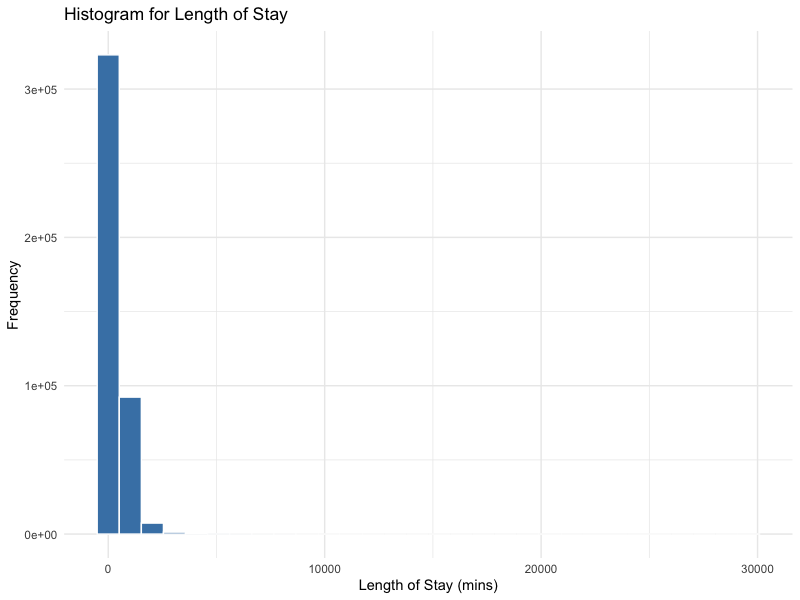

In [18]:
ed_join |> 
  select(los) |> 
  collect() |> 
  drop_na() |>
  ggplot(aes(x = los)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  theme_minimal() +
  labs(
    title = "Histogram for Length of Stay",
    x = "Length of Stay (mins)",
    y = "Frequency"
  )

In [19]:
ed_join |> 
  select(los) |> 
  summarise(
    min = min(los, na.rm = TRUE),
    max = max(los, na.rm = TRUE),
    mean = mean(los, na.rm = TRUE),
    median = median(los, na.rm = TRUE),
    sd = sd(los, na.rm = TRUE),
    na = sum(is.na(los))
  ) |> 
  print()

# A tibble: 1 × 6
    min    max  mean median    sd    na
  <dbl>  <dbl> <dbl>  <dbl> <dbl> <int>
1     1 29584.  430.    328  398.    59


29584 minutes is ~20 days in the ED. This seems unlikely to be real. Use 72 hours (4320 minutes) as an outlier for Length of stay. Tis is very generous, e.g. 24-48 hours might be considered the norm :[Otto et al](https://pmc.ncbi.nlm.nih.gov/articles/PMC9135863/)

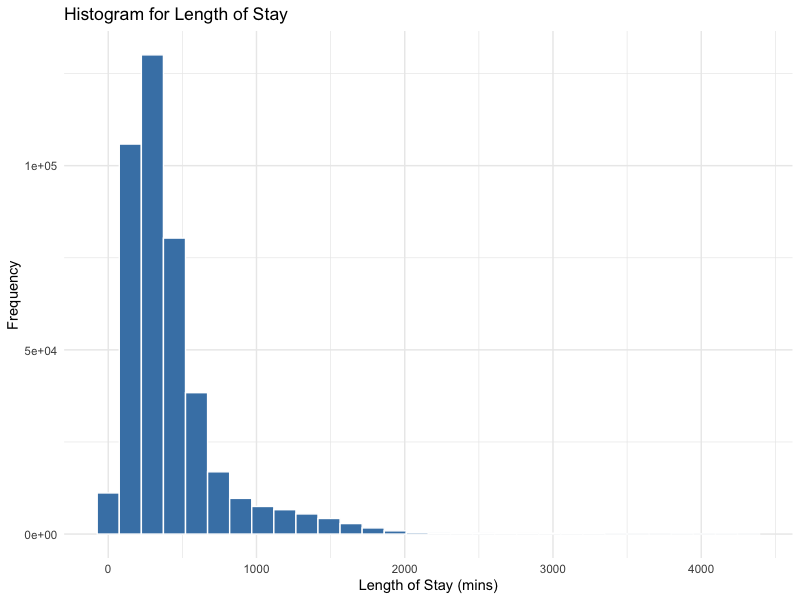

In [20]:
ed_join |> 
  select(los) |> 
  collect() |> 
  mutate(
    los = ifelse(los > 4320, NA, los)
  ) |>
  drop_na() |>
  ggplot(aes(x = los)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  theme_minimal() +
  labs(
    title = "Histogram for Length of Stay",
    x = "Length of Stay (mins)",
    y = "Frequency"
  )

In [21]:
ed_join |> 
  select(los) |> 
  collect() |> 
  mutate(
    los = ifelse(los > 4320, NA, los)
  ) |>
  summarise(
    min = min(los, na.rm = TRUE),
    max = max(los, na.rm = TRUE),
    mean = mean(los, na.rm = TRUE),
    median = median(los, na.rm = TRUE),
    sd = sd(los, na.rm = TRUE),
    na = sum(is.na(los))
  ) |> 
  print()

# A tibble: 1 × 6
    min   max  mean median    sd    na
  <dbl> <dbl> <dbl>  <dbl> <dbl> <int>
1     1  4320  426.    328  369.   359


Thats a better fit with few outliers added. 

In [22]:
ed_join <- ed_join |> 
  collect() |>
  mutate(
    length_of_stay = ifelse(los > 4320, NA, los)
  ) |> 
  arrow_table()

#### Reattended

Create two variables, whether their visit was a 72 hour re-attendance, and how many times they had visited in the last year

In [23]:
ed_join <- ed_join |> 
  group_by(subject_id) |> 
  # Arrange visits chronologically by 'intime'
  arrange(
      subject_id, intime
  ) |> 
  # Lag 'outtime' to get previous visit's outtime
  mutate(
      prev_outtime = lag(outtime),
  # Calculate the time difference in hours
      time_diff_hours = as.numeric(difftime(intime, prev_outtime, units = "hours")),
  # Label revisit as YES if time_diff_hours <= 72, NO otherwise
      revisit_72hrs = if_else(!is.na(time_diff_hours) & time_diff_hours <= 72, "YES", "NO"),
  # Calculate visits in past year
      prior_visits_1yr = map_int(intime, function(current_time) {
          sum(intime < current_time & intime >= (current_time - days(365)))
      })
  ) |> 
  ungroup() |> 
  compute()

Warning message:
In lag(outtime): 
ℹ Expression not supported in Arrow
→ Pulling data into R 


### Died same day

Create a variable for if they died on the same day as their visit (either intime or outtime)

In [24]:
ed_join <- ed_join |> 
    mutate(
        intime_date = as_date(intime),
        outtime_date = as_date(outtime),
        dead_on_day = ifelse(!is.na(dod) & (intime_date == dod | outtime_date == dod), "Yes", "No")
    ) |> 
    compute()

#### Arrival transport

Change arrival transport text to lower case

In [25]:
ed_join <- ed_join |> 
    mutate(arrival_transport = tolower(arrival_transport)) |> 
    compute()

#### Vital signs

Describe vital sign data

In [26]:
cols_to_check <- c(
  "temperature", 
  "heartrate", 
  "o2sat", 
  "sbp", 
  "dbp", 
  "resprate", 
  "vital_temp", 
  "vital_hr", 
  "vital_o2", 
  "vital_sbp", 
  "vital_dbp", 
  "vital_rr", 
  "pain", 
  "vital_pain", 
  "acuity")

In [27]:
ed_join |> 
  select(all_of(cols_to_check)) |>
  head(10) |> 
  collect() |> 
  glimpse()

Rows: 10
Columns: 15
$ temperature <dbl> 98.40, 98.90, 97.80, 98.70, 99.40, 97.50, 98.70, 98.21, 98.80, 98.80
$ heartrate   <dbl> 70, 88, 87, 77, 105, 78, 80, 83, 101, 98
$ o2sat       <dbl> 97, 97, 97, 98, 96, 100, 95, 100, 100, 100
$ sbp         <dbl> 106, 116, 71, 96, 106, 114, 111, 112, 131, 135
$ dbp         <dbl> 63, 88, 43, 50, 57, 71, 72, 81, 62, 85
$ resprate    <dbl> 16, 18, 14, 16, 18, 16, 16, 20, 18, 16
$ vital_temp  <dbl> 97.7, 97.9, 98.2, NA, 98.1, 98.0, 98.7, 98.2, 98.4, 98.6
$ vital_hr    <dbl> 79, 86, 85, 96, 91, 68, 80, 66, 64, 59
$ vital_o2    <dbl> 98, 93, 98, 97, 99, 96, 100, 100, 98, 99
$ vital_sbp   <dbl> 107, 96, 81, 86, 98, 103, 119, 111, 109, 100
$ vital_dbp   <dbl> 60, 57, 38, 45, 60, 74, 84, 62, 69, 78
$ vital_rr    <dbl> 16, 17, 18, 18, 18, 16, 16, 15, 18, 18
$ pain        <chr> "0", "10", "7", "13", "10", "0", "0", "5", "5", "5"
$ vital_pain  <chr> "0", NA, "0", "asleep", NA, "0", "0", "3", "0", "0/10"
$ acuity      <dbl> 3, 3, 2, 2, 3, 2, 2, 3, 3, 3


In [28]:
ed_join |> 
  select(all_of(cols_to_check)) |>
  collect() |> 
  summarise(across(all_of(cols_to_check), ~ sum(is.na(.x)))) |> 
  pivot_longer(everything(), names_to = "variable", values_to = "n_missing") |>
  mutate(
    percentage_missing = n_missing / nrow(ed_join) * 100
  ) |>
  print()


# A tibble: 15 × 3
   variable    n_missing percentage_missing
   <chr>           <int>              <dbl>
 1 temperature     23334               5.49
 2 heartrate       17017               4.01
 3 o2sat           20521               4.83
 4 sbp             18217               4.29
 5 dbp             19015               4.48
 6 resprate        20279               4.77
 7 vital_temp      67413              15.9 
 8 vital_hr        23771               5.60
 9 vital_o2        43173              10.2 
10 vital_sbp       24361               5.74
11 vital_dbp       24361               5.74
12 vital_rr        25385               5.98
13 pain            12841               3.02
14 vital_pain     110783              26.1 
15 acuity           6934               1.63


In [29]:
ed_join |> 
  select(cols_to_check) |>
  mutate(
    across(all_of(cols_to_check), as.numeric)
  ) |>
  collect() |> 
  summarise(
    across(
      all_of(cols_to_check),
      list(
        min = function(x) min(x, na.rm = TRUE),
        max = function(x) max(x, na.rm = TRUE)
      )
    )
  ) |>
  pivot_longer(
    cols = everything(),
    names_to = c("variable"),
    values_to = "value"
  ) |>
  print(n=30)

# A tibble: 30 × 2
   variable           value
   <chr>              <dbl>
 1 temperature_min      0.1
 2 temperature_max    986  
 3 heartrate_min        1  
 4 heartrate_max     1228  
 5 o2sat_min            0  
 6 o2sat_max         9322  
 7 sbp_min              1  
 8 sbp_max         151103  
 9 dbp_min              0  
10 dbp_max         661672  
11 resprate_min         0  
12 resprate_max      1820  
13 vital_temp_min       0  
14 vital_temp_max     989  
15 vital_hr_min         0  
16 vital_hr_max       229  
17 vital_o2_min         0  
18 vital_o2_max      9712  
19 vital_sbp_min        0  
20 vital_sbp_max      854  
21 vital_dbp_min        0  
22 vital_dbp_max    97100  
23 vital_rr_min         0  
24 vital_rr_max       181  
25 pain_min            -1  
26 pain_max           180  
27 vital_pain_min       0  
28 vital_pain_max     100  
29 acuity_min           1  
30 acuity_max           5  


Warning messages:
1: Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(cols_to_check)

  # Now:
  data %>% select(all_of(cols_to_check))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated. 
2: There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(all_of(cols_to_check), as.numeric)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run ]8;;x-r-run:dplyr::last_dplyr_warnings()dplyr::last_dplyr_warnings()]8;; to see the 1 remaining warning. 


There are missing data, and pain and vital_pain, which should be numbers, are strings (and include e.g. "asleep"). Temperature, heart rate, O2sat, resp rate and sbp/dbp columns contain values that are not on the scales, unrealistic values. All of these will need to be cleaned.   
First, I'll start with the pain columns. Group by the values and look at the least common

In [30]:
ed_join |> 
  select(pain) |> 
  collect() |>
  filter(!is.na(pain)) |>
  group_by(pain) |>
  count(sort = T) |> 
  print(n=30)

# A tibble: 784 × 2
# Groups:   pain [784]
   pain          n
   <chr>     <int>
 1 0        140638
 2 8         41731
 3 10        40966
 4 7         31399
 5 5         29201
 6 6         25201
 7 9         20210
 8 4         19707
 9 3         16109
10 2         13894
11 13        10915
12 1          5898
13 unable     3821
14 Critical   1695
15 uta        1632
16 UTA        1601
17 ua         1201
18 UA          478
19 u/a         355
20 c           319
21 Unable      288
22 6-7         140
23 crit        140
24 5-6         135
25 7-8         134
26 8-9         116
27 critical    110
28 3-4         109
29 yes         109
30 8.5          99
# ℹ 754 more rows
# ℹ Use `print(n = ...)` to see more rows


In [31]:
ed_join |> 
  select(pain) |> 
  collect() |>
  filter(!is.na(pain)) |>
  group_by(pain) |>
  count() |> 
  arrange(n) |> 
  print(n=20)

# A tibble: 784 × 2
# Groups:   pain [784]
   pain                                                            n
   <chr>                                                       <int>
 1 "\" alittle\""                                                  1
 2 "\"10\""                                                        1
 3 "\"10++\""                                                      1
 4 "\"100\""                                                       1
 5 "\"1000\""                                                      1
 6 "\"110\""                                                       1
 7 "\"13\""                                                        1
 8 "\"14\""                                                        1
 9 "\"200\""                                                       1
10 "\"22\""                                                        1
11 "\"50\""                                                        1
12 "\"60\""                                                 

Many of these can be saved, if they contain numbers:

In [32]:
word_numbers <- c(
  "zero" = 0, "one" = 1, "two" = 2, "three" = 3, "four" = 4, 
  "five" = 5, "six" = 6, "seven" = 7, "eight" = 8, "nine" = 9, 
  "ten" = 10
)
ed_join_pain <- ed_join |>
  collect() |>
  mutate(
    # trim whitespace
    pain = str_trim(pain),
    vital_pain = str_trim(vital_pain),
    # now replace the word with numbers
    pain = map_chr(pain, ~ if (.x %in% names(word_numbers)) word_numbers[.x] else .x),
    vital_pain = map_chr(vital_pain, ~ if (.x %in% names(word_numbers)) word_numbers[.x] else .x),
    # if pain includes a range , e.g. "5-6" take the first number
    pain = str_replace(pain, "^(\\d+)-\\d+$", "\\1"),
    vital_pain = str_replace(vital_pain, "^(\\d+)-\\d+$", "\\1"),
    # Take The first word from pain (i.e. if 10 20, take 10)
    pain = word(pain, 1),
    vital_pain = word(vital_pain, 1),
    # # Convert to numeric
    pain = as.numeric(pain),
    vital_pain = as.numeric(vital_pain),
    # Round_numbers up. I choose to round halfs up
    pain = round_half_up(pain),
    vital_pain = round_half_up(vital_pain),
    # If pain is over 10, set to 10,if under 0, set to 0
    pain = case_when(
      pain > 10 ~ 10, 
      pain < 0 ~ 0, 
      TRUE ~ pain),
    vital_pain = case_when(
      vital_pain > 10 ~ 10, 
      vital_pain < 0 ~ 0, 
      TRUE ~ vital_pain
    ) 
  ) |> 
  arrow_table()

Warning message:
There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `pain = as.numeric(pain)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run ]8;;x-r-run:dplyr::last_dplyr_warnings()dplyr::last_dplyr_warnings()]8;; to see the 1 remaining warning. 


Examine the new pain column

In [33]:
print("how many missing pain values are there?")
ed_join_pain |> 
  select(pain) |> 
  collect() |>
  filter(is.na(pain)) |>
  count() |> 
  print()

[1] "how many missing pain values are there?"
# A tibble: 1 × 1
      n
  <int>
1 27009


Now for blood pressure. I'll use the algorithm to identify outliers from [Arvantis et al](https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.120.049819) which is mean+3SD. First, I'll need to see what the minim and maximum are

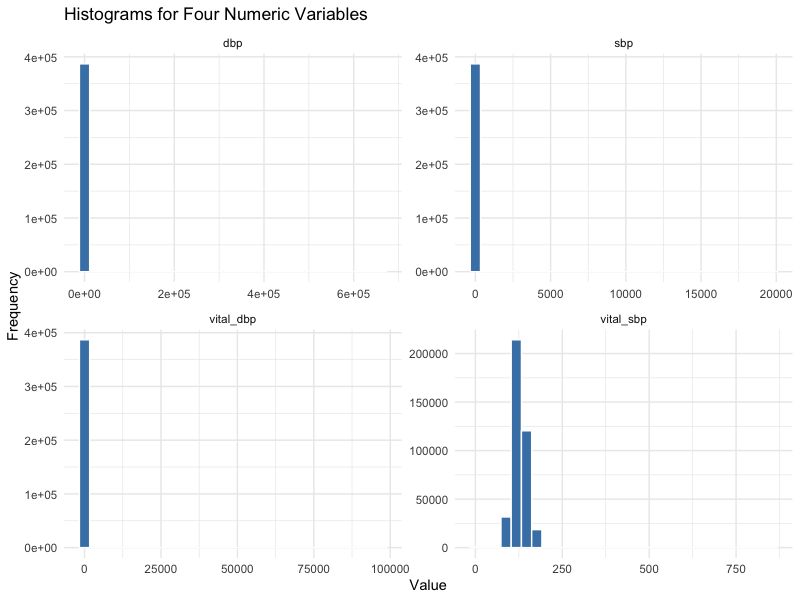

In [34]:
ed_join_pain|> 
  select(dbp, sbp, vital_sbp, vital_dbp) |>
  collect() |> 
  drop_na() |> 
  pivot_longer(
    cols = everything(),
    names_to = c("variable"),
    values_to = "value"
  ) |> 
  ggplot(aes(x = value)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  facet_wrap(~ variable, scale = "free") +
  theme_minimal() +
  labs(
    title = "Histograms for Four Numeric Variables",
    x = "Value",
    y = "Frequency"
  )

In [35]:
ed_join_pain |> 
  select(dbp, sbp, vital_sbp, vital_dbp) |>
  collect() |> 
  drop_na() |> 
  summarise(
    across(
      everything(),
      list(
        min = function(x) min(x, na.rm = TRUE),
        max = function(x) max(x, na.rm = TRUE)
      )
    )
) |> 
  pivot_longer(
    cols = everything(),
    names_to = c("variable"),
    values_to = "value"
  ) |> 
  print()

# A tibble: 8 × 2
  variable       value
  <chr>          <dbl>
1 dbp_min            0
2 dbp_max       661672
3 sbp_min            5
4 sbp_max        19734
5 vital_sbp_min      0
6 vital_sbp_max    854
7 vital_dbp_min      0
8 vital_dbp_max  97100


These extreme values will mean identifying the 3SD will be impossible. I'll need to trim them first. I use the values provided by [Afshar](https://academic.oup.com/jamiaopen/article/4/3/ooab057/6334273) to set the initial range

In [36]:
ed_join_bp <- ed_join_pain |>
  mutate(
    dbp = ifelse(dbp < 5 |dbp > 225, NA_real_, dbp),
    sbp = ifelse(sbp < 20 |sbp > 300, NA_real_, sbp),
    vital_dbp = ifelse(vital_dbp < 5 |vital_dbp > 225, NA_real_, vital_dbp),
    vital_sbp = ifelse(vital_sbp < 20 |vital_sbp > 300, NA_real_, vital_sbp)
  ) |>
  compute()

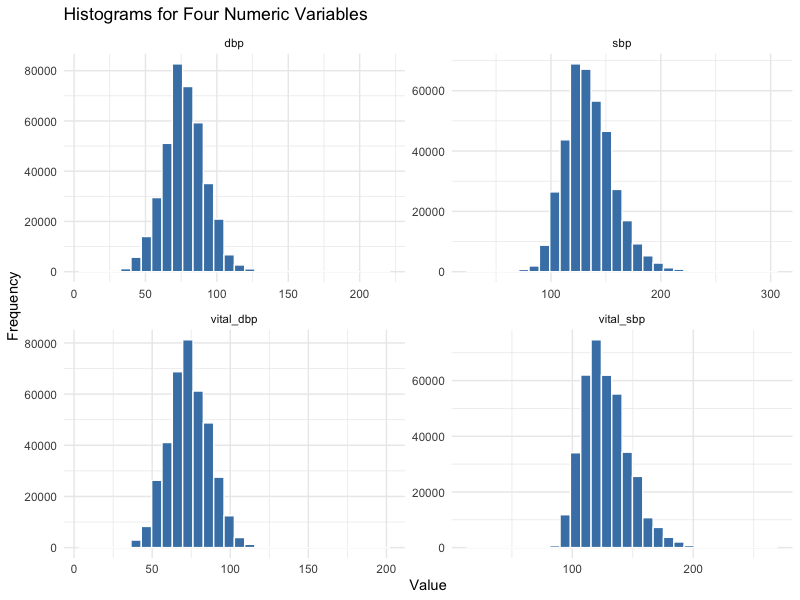

In [37]:
ed_join_bp|> 
  select(dbp, sbp, vital_sbp, vital_dbp) |>
  collect() |> 
  drop_na() |> 
  pivot_longer(
    cols = everything(),
    names_to = c("variable"),
    values_to = "value"
  ) |> 
  ggplot(aes(x = value)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  facet_wrap(~ variable, scale = "free") +
  theme_minimal() +
  labs(
    title = "Histograms for Four Numeric Variables",
    x = "Value",
    y = "Frequency"
  )

In [38]:
ed_join_bp |> 
  select(dbp, sbp, vital_sbp, vital_dbp) |>
  collect() |> 
  drop_na() |> 
  summarise(
    across(
      everything(),
      list(
        min = function(x) min(x, na.rm = TRUE),
        max = function(x) max(x, na.rm = TRUE)
      )
    )
) |> 
  pivot_longer(
    cols = everything(),
    names_to = c("variable"),
    values_to = "value"
  ) |> 
  print()

# A tibble: 8 × 2
  variable      value
  <chr>         <dbl>
1 dbp_min           5
2 dbp_max         215
3 sbp_min          26
4 sbp_max         299
5 vital_sbp_min    20
6 vital_sbp_max   268
7 vital_dbp_min     5
8 vital_dbp_max   197


For Temperature, heartrate and o2sat I identify outliers using the ranges provided in [Gabyan et al](https://pmc.ncbi.nlm.nih.gov/articles/PMC5935002/). For respiratory rate I use the range from [Lovett et al](https://www.sciencedirect.com/science/article/pii/S0196064404006493) 

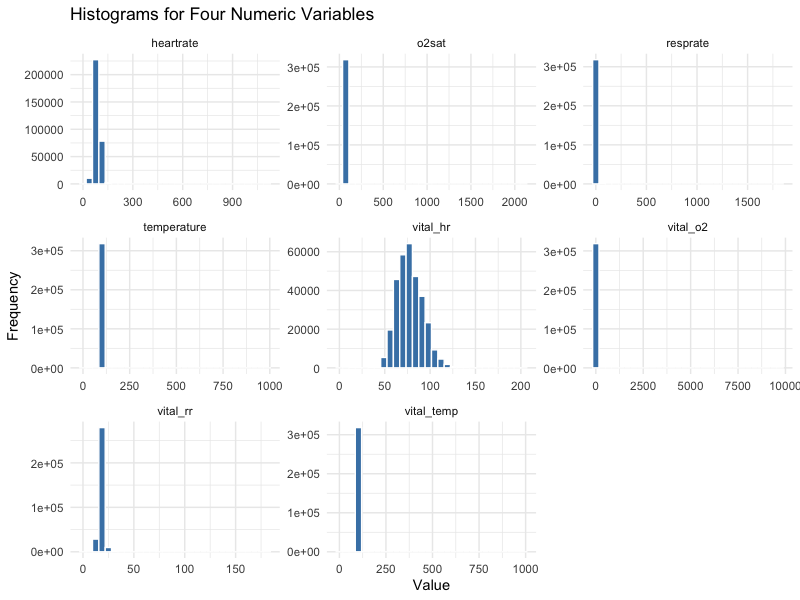

In [39]:
ed_join_bp |> 
  select(temperature, heartrate, o2sat, resprate, vital_temp, vital_hr, vital_o2, vital_rr) |> 
  collect() |>
  drop_na() |> 
  pivot_longer(
    cols = everything(),
    names_to = c("variable"),
    values_to = "value"
  ) |> 
  ggplot(aes(x = value)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  facet_wrap(~ variable, scale = "free") +
  theme_minimal() +
  labs(
    title = "Histograms for Four Numeric Variables",
    x = "Value",
    y = "Frequency"
  )

In [40]:
ed_join_vital <- ed_join_bp |> 
  collect() |>
# set the temperature, heartrate, o2sat sbp, dbp, and rr to valid values or NA, 
mutate(
  temperature = ifelse(between(temperature, 70, 105), temperature, NA_real_),
  heartrate = ifelse(between(heartrate, 25, 225), heartrate, NA_real_),
  o2sat = ifelse(between(o2sat, 30, 100), o2sat, NA_real_),
  resprate = ifelse(between(resprate, 5, 50), resprate, NA_real_), # 5 is also the minimum ventilation rate for intubate patients
  vital_temp = ifelse(between(vital_temp, 70, 105), vital_temp, NA_real_),,
  vital_hr = ifelse(between(vital_hr, 25, 225), vital_hr, NA_real_),
  vital_o2 = ifelse(between(vital_o2, 30, 100), vital_o2, NA_real_),
  vital_rr = ifelse(between(vital_rr, 5, 50), vital_rr, NA_real_)
) |> 
compute()

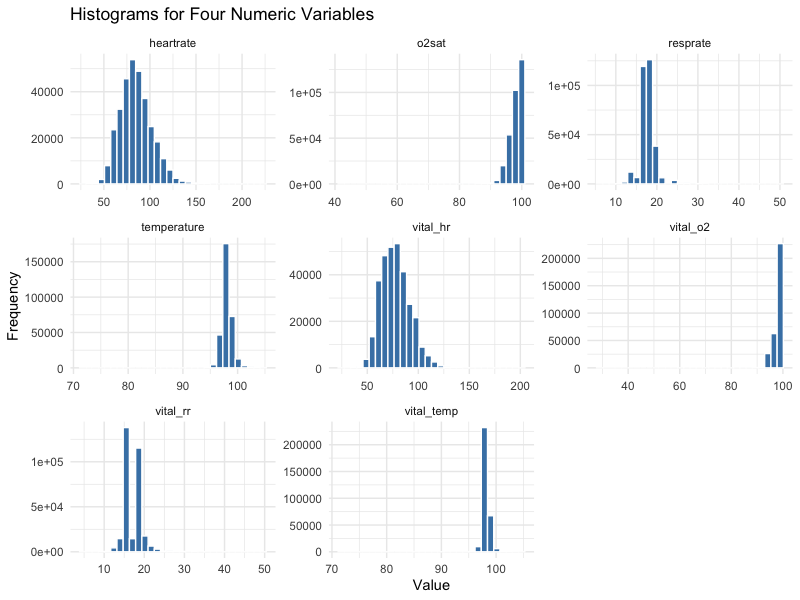

In [41]:
ed_join_vital |> 
  select(temperature, heartrate, o2sat, resprate, vital_temp, vital_hr, vital_o2, vital_rr) |> 
  collect() |>
  drop_na() |> 
  pivot_longer(
    cols = everything(),
    names_to = c("variable"),
    values_to = "value"
  ) |> 
  ggplot(aes(x = value)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white") +
  facet_wrap(~ variable, scale = "free") +
  theme_minimal() +
  labs(
    title = "Histograms for Four Numeric Variables",
    x = "Value",
    y = "Frequency"
  )

## Add derivative variables

Add the [CCI index](https://en.wikipedia.org/wiki/Charlson_Comorbidity_Index)

In [42]:
diagnoses_formatted <- ed_join_vital |>
  select(
    id = stay_id, 
    icd_codes, 
    version = icd_version) |> 
  collect() |> 
  mutate(
    version = if_else(version == 9, "icd9", "icd10"),
    ) |> 
  separate_longer_delim(icd_codes, ",") |> 
  rename(code = icd_codes) 

cci_cat_10 <- comorbidity::comorbidity(
  x = diagnoses_formatted |> filter(version == "icd10"),
  id = "id",
  code = "code",
  map = "charlson_icd10_quan",        # choose "charlson" or "elixhauser"
  assign0 = TRUE,    # or "quan" for weighted score
) 
cci_score_10 <- score(cci_cat_10, weights = NULL, assign0=F)
cci_cat_10 <- cci_cat_10 |> 
mutate(
    cci_score = cci_score_10,
    version = "icd10"
    )

cci_cat_9 <- comorbidity::comorbidity(
  x = diagnoses_formatted |> filter(version == "icd9"),
  id = "id",
  code = "code",
  map = "charlson_icd9_quan",        # choose "charlson" or "elixhauser"
  assign0 = TRUE,    # or "quan" for weighted score
) 

cci_score_9 <- score(cci_cat_9, weights = NULL, assign0=F)
cci_cat_9 <- cci_cat_9 |> 
mutate(
    cci_score = cci_score_9,
    version = "icd9"
    )
cci_scores  <- bind_rows(cci_cat_10, cci_cat_9) 
# Count rows where all comorbidity columns (except id) are 0
print(paste("Rows with Charlson missing scores"))
print(cci_scores |>
  filter(if_all(-id, ~ . == 0)) |>
  group_by(version) |>
  count())

# Join to ed_join
ed_join_cc <- ed_join_vital |> 
left_join(
  cci_scores |> 
    select(-version),
  by = join_by(stay_id==id)
) |> 
compute()

[1] "Rows with Charlson missing scores"
# A tibble: 0 × 2
# Groups:   version [0]
# ℹ 2 variables: version <chr>, n <int>


Add the ICD code chapter

In [43]:
ed_join_icd <- ed_join_cc |> 
  collect() |>
  mutate(
    icd_chapter = case_when(
      icd_version == 10 & str_detect(primary_code, "^A|^B") ~ "Infectious and parasitic diseases",
      icd_version == 10 & str_detect(primary_code, "^C|^D0|^D1|^D2|^D3|^D4") ~ "Neoplasms",
      icd_version == 10 & str_detect(primary_code, "^D5|^D6|^D7|^D8") ~ "Diseases of the blood and blood-forming organs",
      icd_version == 10 & str_detect(primary_code, "^E") ~ "Endocrine, nutritional and metabolic diseases",
      icd_version == 10 & str_detect(primary_code, "^F") ~ "Mental disorders",
      icd_version == 10 & str_detect(primary_code, "^G") ~ "Diseases of the nervous system",
      icd_version == 10 & str_detect(primary_code, "^H0|^H1|^H2|^H3|^H4|^H5") ~ "Diseases of the eye and adnexa",
      icd_version == 10 & str_detect(primary_code, "^H6|^H7|^H8|^H9") ~ "Diseases of the ear and mastoid process",
      icd_version == 10 & str_detect(primary_code, "^I") ~ "Diseases of the circulatory system",
      icd_version == 10 & str_detect(primary_code, "^J") ~ "Diseases of the respiratory system",
      icd_version == 10 & str_detect(primary_code, "^K") ~ "Diseases of the digestive system",
      icd_version == 10 & str_detect(primary_code, "^L") ~ "Diseases of the skin and subcutaneous tissue",
      icd_version == 10 & str_detect(primary_code, "^M") ~ "Diseases of the musculoskeletal system",
      icd_version == 10 & str_detect(primary_code, "^N") ~ "Diseases of the genitourinary system",
      icd_version == 10 & str_detect(primary_code, "^O") ~ "Pregnancy, childbirth and the puerperium",
      icd_version == 10 & str_detect(primary_code, "^P") ~ "Certain conditions originating in the perinatal period",
      icd_version == 10 & str_detect(primary_code, "^Q") ~ "Congenital anomalies",
      icd_version == 10 & str_detect(primary_code, "^R") ~ "Ill-defined conditions",
      icd_version == 10 & str_detect(primary_code, "^S|^T") ~ "Injury and poisoning",
      icd_version == 10 & str_detect(primary_code, "^Z") ~ "Factors influencing health status/contact with health services",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")),  1, 139)~ "Infectious and parasitic diseases",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 140, 239)~ "Neoplasms",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 240, 279)~ "Endocrine, nutritional and metabolic diseases",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 280, 289)~ "Diseases of the blood and blood-forming organs",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 290, 319)~ "Mental disorders",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 320, 389)~ "Diseases of the nervous system",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 390, 459)~ "Diseases of the circulatory system",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 460, 519)~ "Diseases of the respiratory system",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 520, 579)~ "Diseases of the digestive system",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 580, 629)~ "Diseases of the genitourinary system",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 630, 679)~ "Pregnancy, childbirth and the puerperium",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 680, 709)~ "Diseases of the skin and subcutaneous tissue",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 710, 739)~ "Diseases of the musculoskeletal system",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 740, 759)~ "Congenital anomalies",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 760, 779)~ "Certain conditions originating in the perinatal period",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 780, 799)~ "Ill-defined conditions",
      icd_version == 9 & between(as.numeric(str_extract(primary_code, "^[0-9]{3}")), 800, 999)~ "Injury and poisoning",
      icd_version == 9 & str_detect(primary_code, "^V") ~ "Factors influencing health status/contact with health services",
      TRUE ~ "Other"
    )
  ) |> 
  arrow_table()

## Add the outcome columns:

First, the NYU-ED outcome

In [49]:
nyu_10  <- read_excel(
    "NYU ED Algorithm - ICD10 Codes - Updated 2.4.25.xlsx"
    ) |> 
    clean_names()  |> 
    rename(
        code = icd10,
        emergent_pc = emergent_pc_treatable, 
        ed_prevent =  ed_care_needed_preventable_avoi,
        ed_needed = ed_care_needed_not_preventable
    ) |> 
    mutate(nyu_version = 10) |> 
    select(-icd10_description)

nyu_9  <- read_excel(
    "NYU_ED_Algorithm_-_ICD-9_Codes_-_6.23.15.xlsx"
    ) |> 
    clean_names()   |> 
    rename(
        code = discharge_dx,
        emergent_pc = emergent_pc_treatable, 
        ed_prevent =  ed_care_needed_preventable_avoi,
        ed_needed = ed_care_needed_not_preventable
    ) |> 
    select(-dx_short_name,-dx_name,-post2009) |> 
    mutate(nyu_version = 9)

nyu_o <- bind_rows(nyu_9,nyu_10)    

#The Extension
nyu_ex10 <- read_tsv("hesr12638-sup-0007-appendixs7.txt", show_col_types = F) |> 
    rename(
        code = icd10,
        non_emergent = noner,
        emergent_pc = epct,
        ed_needed  = edcnpa,
        ed_prevent = edcnnpa
    )  |> 
    mutate(
        "unclassified" = 0,
        nyu_version = 10,
    )

nyu_ex9 <- read_tsv("hesr12638-sup-0007-appendixs6.txt", show_col_types = F) |> 
    rename(
        code = ICD9,
        non_emergent = noner,
        emergent_pc = epct,
        ed_needed  = edcnpa,
        ed_prevent = edcnnpa
    )  |> 
    mutate(
        "unclassified" = 0,
        nyu_version = 9,
    )
# Join the NYU extension to the main NYU table
nyu  <- nyu_o |> 
    anti_join(nyu_ex10, join_by(code, nyu_version)) |>
    bind_rows(nyu_ex10) |> 
    anti_join(nyu_ex9, join_by(code, nyu_version)) |>
    bind_rows(nyu_ex9)

nyu_code <- paste0("^(", paste(nyu$code, collapse = "|"))

In [50]:
ed_join_nyu <- ed_join_icd |>
    collect() |>
    left_join(nyu, join_by(primary_code == code, icd_version ==nyu_version)) |> 
    mutate(
        nyu_sum = map2_dbl(non_emergent, emergent_pc, ~sum(.x,.y)),
        nyu = if_else(nyu_sum>0.5, true = 1, false = 0)
    ) |> 
    arrow_table()


ed_join_nyu |> 
    collect() |> 
    group_by(nyu) |> 
    count()

# A tibble: 2 × 2
# Groups:   nyu [2]
    nyu      n
  <dbl>  <int>
1     0 273103
2     1 151604

The resources outcome

In [51]:
dispo_list <- c("ADMITTED","TRANSFER", "EXPIRED")
ed_join_res <- ed_join_nyu |>
    collect() |>
    mutate(
        res = case_when(!disposition %in% dispo_list & is.na(rhythm) & is.na(pre_gsn_count) & dead_on_day == "No" ~1, T~0),
    ) |> 
    arrow_table()

ed_join_res |> 
    collect() |> 
    group_by(res) |> 
    count() |> 
    print()

# A tibble: 2 × 2
# Groups:   res [2]
    res      n
  <dbl>  <int>
1     0 331343
2     1  93364


The acuity outcome

In [52]:
ed_join_acuity  <-  ed_join_res |> 
    collect() |>
    mutate(
        acuity_out = case_when(!is.na(acuity) & acuity>3 ~1, 
                               !is.na(acuity) & acuity<4 ~ 0,
                               T~NA_real_
                               ),
    ) |> 
    arrow_table()

ed_join_acuity |> 
collect() |> 
group_by(acuity_out) |> 
count()

# A tibble: 3 × 2
# Groups:   acuity_out [3]
  acuity_out      n
       <dbl>  <int>
1          0 388221
2          1  29552
3         NA   6934

To encode the chief complaint, I use A BERT transformer in this [notebook]('2_chiefcomp.ipynb')

# Save

In [53]:
write_parquet(ed_join_acuity |>collect(), "ed_join_cc.parquet", compression = "gzip")